### Step 1: Construct the assays & compounds table

#### 1.1 Construct the assays table,with fields as the following

CID VARCHAR(30) PRIMARY KEY,  
r_inhibition_at_20_uM DOUBLE,  
r_inhibition_at_50_uM DOUBLE,  
r_avg_IC50 DOUBLE,  
f_inhibition_at_20_uM DOUBLE,  
f_inhibition_at_50_uM DOUBLE,  
f_avg_IC50 DOUBLE,  
f_avg_pIC50 DOUBLE  


In [1]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from rdkit.ML.Cluster.Butina import ClusterData
import csv
from pathlib import Path

C:\Users\henri\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\henri\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [2]:
#file names of databases
data_file = Path('activity_data.csv')
db_file = Path('MPro_binding.db')

In [3]:
# # 1: drop the database
# for table_name in ('compounds','assays'):
#     sql.connect(db_file).execute('DROP TABLE IF EXISTS ' + table_name)

In [4]:
# # 2: create a new database
# conn = sql.connect(db_file)
# conn.execute('''
# CREATE TABLE assays
# (
#     CID VARCHAR(20) PRIMARY KEY,
#     r_inhibition_at_20_uM DECIMAL,
#     r_inhibition_at_50_uM DECIMAL,
#     r_avg_IC50 DECIMAL,
#     f_inhibition_at_20_uM DECIMAL,
#     f_inhibition_at_50_uM DECIMAL,
#     f_avg_IC50 DECIMAL,
#     f_avg_pIC50 DECIMAL
# )

# ''')

# conn.execute('''
# CREATE TABLE compounds
# (
#     CID VARCHAR(20) PRIMARY KEY,
#     SMILES VARCHAR(2000) NOT NULL,
#     FOREIGN KEY(CID) REFERENCES assays(CID) 
# )
# ''')


In [5]:
# # 3: Add records to the table assays 
# itemlist = []
# with open(data_file,encoding="utf8") as csvfile:
#     reader = csv.DictReader(csvfile,delimiter=',')
#     for row in reader:
#         itemlist.append((row['CID'],row['r_inhibition_at_20_uM'],
#                          row['r_inhibition_at_50_uM'],row['r_avg_IC50'],
#                          row['f_inhibition_at_20_uM'],row['f_inhibition_at_50_uM'],
#                          row['f_avg_IC50'],row['f_avg_pIC50']))
# print(itemlist)
# conn = self.get_conn()
# conn.executemany('INSERT INTO <TABLE> (Col1, Col2) VALUES(?,?)', ((1,2), (2,3)))
# print('###############################')
        
# # 4: Add records to the table compounds
# itemlist = []
# with open(data_file, newline='',encoding="utf8") as csvfile:
#     reader = csv.DictReader(csvfile)
#     for row in reader:
#         print(type(row['CID']))
#         print(type(row['SMILES']))
#         itemlist.append((row['CID'],row['SMILES']))

# #print(itemlist)
# conn = sql.connect(db_file)
# conn.executemany("INSERT INTO compounds (CID,SMILES) VALUES(?,?)",itemlist)
                
                

In [6]:
# # 5. check whether records have been inserted successfully (show the table)
# '''
# for table in ('assays','compounds'):
#     cur = sql.connect(db_file).execute('SELECT sql FROM sqlite_master WHERE name=\'' + table + '\'')
#     row = cur.fetchall()
#     if row is not None:
#         print(table+'\n')
#         print(row[0:5])
#     else:
#         print('Table ' + table + ' not found')
# '''
# conn = sql.connect(db_file)
# result = conn.execute('''
#     SELECT
#         SMILES
#     FROM 
#         compounds''')
# print(result)
# for row in result:
#     print(row)


### We give up sql, and we used pandas instead

In [7]:
#Create assays and compounds tabel from the activity data.
df_temp = pd.read_csv(data_file)
assays = df_temp[['CID','r_inhibition_at_20_uM','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_20_uM','f_inhibition_at_50_uM','f_avg_IC50','f_avg_pIC50']]
compounds = df_temp[['CID','SMILES']]

In [8]:
assays.head()

,CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50
0,LUO-POS-e1dab717-11,NaN,NaN,NaN,NaN,NaN,0.275118,NaN
1,LUO-POS-e1dab717-12,NaN,NaN,NaN,NaN,NaN,0.202767,NaN
2,MAT-POS-e48723dc-1,NaN,NaN,NaN,NaN,NaN,55.453947,NaN
3,MAT-POS-e48723dc-2,NaN,NaN,NaN,NaN,NaN,0.050000,NaN
4,LUO-POS-9931618f-2,NaN,NaN,NaN,NaN,NaN,0.052757,NaN


In [9]:
compounds.head()

,CID,SMILES
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...


### Step 2: data exploration 

#### 2.1: Molecular descriptors

In [10]:
#%pip install rdkit

In [11]:
import rdkit.Chem as Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors

In [12]:
def calculate_descriptors(smile):
    '''
    Function to calculate the molecular descriptors for Lipinski's rule of five.
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    '''
    
    molecule = Chem.MolFromSmiles(smile)
    if molecule:
        hbd, hba, mw, logpow = [x(molecule) for x in [NumHDonors, NumHAcceptors, MolWt, MolLogP]]
        res = [hbd, hba, mw, logpow]
    else:
        res = [None] * 4
    return res

In [14]:
# Add molecular descriptors to compounds table
hbd, hba, mw, logpow =[],[],[],[]
for i in range(len(compounds)):
    hbd_temp, hba_temp, mw_temp, pow_temp = calculate_descriptors(compounds['SMILES'][i])
    hbd.append(hbd_temp)
    hba.append(hba_temp)
    mw.append(mw_temp)
    logpow.append(pow_temp)
compounds['hbd'] = hbd
compounds['hba'] = hba
compounds['mw'] = mw
compounds['pow'] = logpow

C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Lipinski's rule of five criteria: 
* 5 or fewer hydrogen bond donors;
* 10 or fewer hydrogen bond acceptors;
* A molecular weight (MW) of less than 500 Daltons;
* An octanol-water partition coefficient (log Po/w) of less than 5. Larger log Po/w means more lipophilic (i.e., less water soluble).

In [15]:
# Select compounds based on Lipinski's rule of five
print('Total number of compounds: ',len(compounds))
compounds_lip_strict = compounds.loc[(compounds['hbd']<=5) & (compounds['hba']<=10) & (compounds['mw']<500) & (compounds['pow']<5)]
print('Number of compounds after selected by Lipinski rule: ',len(compounds_lip_strict))
assays_lip_strict = assays.loc[(compounds['hbd']<=5) & (compounds['hba']<=10) & (compounds['mw']<500) & (compounds['pow']<5)]
print('Number of assays after Lipinski rule: ',len(assays_lip_strict))

Total number of compounds:  2062
Number of compounds after selected by Lipinski rule:  1539
Number of assays after Lipinski rule:  1539


In [16]:
#NOTE: need to update the figures to ggplot, add xy-labels etc

In [17]:
%matplotlib inline
def plot_hist(data_1,data_2,nbins=100):
    data_1 = data_1.to_numpy()
    data_2 = data_2.to_numpy()
    plt.hist(data_1[~np.isnan(data_1)],bins=nbins,alpha=0.3,density=True)
    plt.hist(data_2[~np.isnan(data_2)],bins=nbins,alpha=0.3,density=True)

198.0


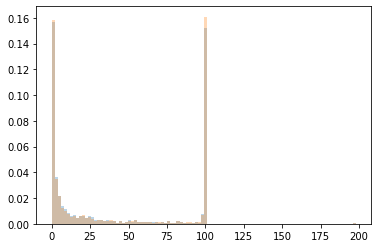

In [18]:
print(max(assays['f_avg_IC50']))
plot_hist(assays['f_avg_IC50'],assays_lip_strict['f_avg_IC50'])

In [19]:
# Select compounds based on meeting at least 3 of the Lipinski's rule of five citeria
compounds_lip = compounds[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]
assays_lip = assays[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]
print('Number of compounds after less strict lipinski rule: ',len(compounds_lip))

Number of compounds after less strict lipinski rule:  1974


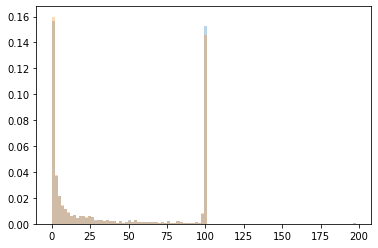

In [20]:
plot_hist(assays['f_avg_IC50'],assays_lip['f_avg_IC50'])

By filtering the compounds in a less strict way, we definitely obtained more compounds!


#### 2.2 ECFP fingerprints

In [21]:
# Check whether we have revised the compounds
len(compounds)

2062

In [30]:
from rdkit.Chem import AllChem
from rdkit.DataStructs import FingerprintSimilarity,DiceSimilarity

In [31]:
def ECFP(smile,radius=2,nBits=2048):
    '''
    Function to determine the ECFP (Morgan) fingerprints.
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    radius: integer
        Measure of the 'local' information captured by the fingerprint
    nBits = integer
        length of the fingerprint
    '''
    
    molecule = Chem.MolFromSmiles(smile)
    return AllChem.GetMorganFingerprintAsBitVect(molecule,radius,nBits=nBits)

In [32]:
# Add ECFP to the compounds table 
ECFP_temp = []
for i in range(len(compounds)):
    ECFP_temp.append(ECFP(compounds['SMILES'][i]))
compounds['ECFP'] = ECFP_temp

C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [33]:
compounds.head()

,CID,SMILES,hbd,hba,mw,pow,ECFP
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,1,5,498.992,2.7033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,1,5,525.030,3.0934,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,1,4,448.910,2.7647,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [34]:
def compute_similarity(fingerprint_1,fingerprint_2):
    '''
    Function to compute the Tanimoto (a.k.a. Jaccard) index between two fingerprints
    
    Parameters
    ----------
    fingerprint_1: 
        Bit vector representing a chemical molecular structure
    fingerprint_2: 
        Bit vector representing a chemical molecular structure
    '''
    
    return FingerprintSimilarity(fingerprint_1,fingerprint_2, metric=DiceSimilarity)

In [35]:
# Construct similarity matrix of the Tanimoto index values
similarity_matrix = np.zeros((len(compounds),len(compounds)))
for i in range(len(compounds)):
    for j in range(len(compounds)):
        similarity_matrix[i,j] = compute_similarity(compounds['ECFP'][i],compounds['ECFP'][j])

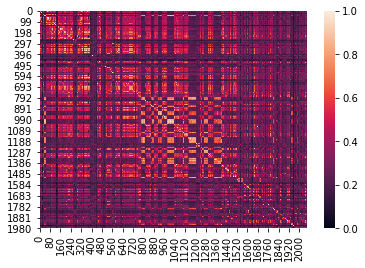

In [36]:
# Create a heatmap of the similarity matrix
seaborn.heatmap(similarity_matrix)

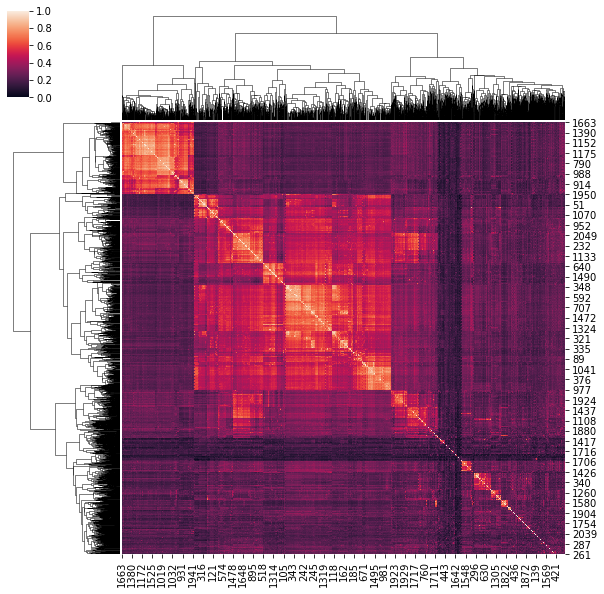

In [54]:
# Add clusters to heatmap
seaborn.clustermap(similarity_matrix)

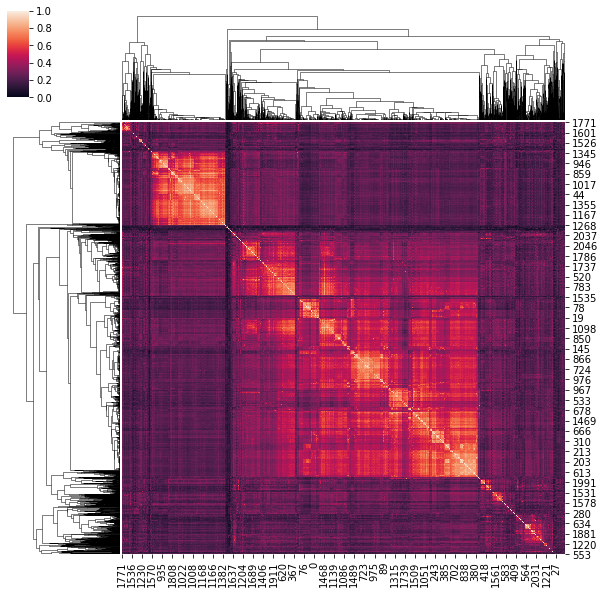

In [105]:
#
seaborn.clustermap(similarity_matrix, metric='correlation')


In [89]:
# determine the indices with the higest similarity score
from rdkit.Chem import Draw
from collections import Counter

#Determine the highest similarity score
dict_occurence_similarityscore = Counter(similarity_matrix.flatten())
sorted_dict_occurence_ss = dict(sorted(dict_occurence_similarityscore.items()))
for x in list(sorted_dict_occurence_ss)[-2:-1]:
    print('{}: {}'.format(x, sorted_dict_occurence_ss[x]))
    highest_score = x

#determine the indices with the highest similarity score
i, j = np.where(np.isclose(similarity_matrix, highest_score))
print('Index of highest similarity score: x: {}, y: {}'.format(i[0], j[0]))

0.9855072463768116: 2
Index of highest similarity score: x: 346, y: 698


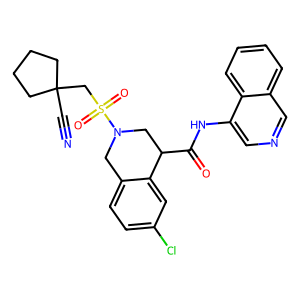

In [90]:
#draw the structures
m1 = Chem.MolFromSmiles(compounds['SMILES'][i[0]])
Draw.MolToImage(m1)

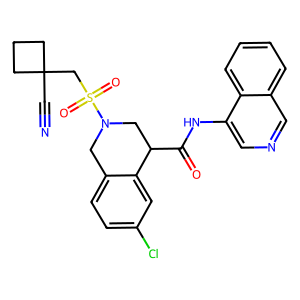

In [91]:
m2 = Chem.MolFromSmiles(compounds['SMILES'][j[0]])
Draw.MolToImage(m2)

In [55]:
# Study Murcko Scaffolds
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

In [56]:
def generate_murcko_scaffolds(smile):
    '''
    Function to determine the murcko scaffold
    
    Parameters
    ----------
    smile: SMILES string
        Representation of chemical molecule structure
    '''
    
    m = Chem.MolFromSmiles(smile)
    return Chem.MolToSmiles(Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(m))

In [57]:
# Store the Murcko scaffolds 
compounds_scaffold = compounds.copy()
mscaffold_temp = []
for i in range(len(compounds_scaffold)):
    mscaffold_temp.append(generate_murcko_scaffolds(compounds_scaffold['SMILES'][i]))
compounds_scaffold['murcko'] = mscaffold_temp

In [58]:
# Determine occurence of every Murcko scaffold
compounds_scaffold['murcko'].value_counts()

O=C(Cc1ccccc1)Nc1cncc2ccccc12                                    98
O=C(Nc1cncc2ccccc12)C1CCOc2ccccc21                               81
O=C(Nc1cncc2ccccc12)C1CNCc2ccccc21                               48
O=C1NCC(C(=O)Nc2cncc3ccccc23)c2ccccc21                           43
O=C(Cc1ccccc1)Nc1cccnc1                                          33
                                                                 ..
O=C(C(c1cccnc1)N(C(=O)c1cocn1)c1ccccc1)N1CCC(c2ccccc2)CC1         1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(-n2ccnn2)cc1      1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1ccon1)c1ccccc1                1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(N2CCCC2=O)cc1     1
O=C(Nc1ccccc1)Nc1c[nH]c2ncccc12                                   1
Name: murcko, Length: 1179, dtype: int64

In [ ]:
#Store table containing murcko scaffolds
df_murckoscaffolds = pd.DataFrame(compounds_scaffold['murcko'].value_counts())
df_murckoscaffolds.index.name = 'murcko'
df_murckoscaffolds.columns = ['count']
# df_murckoscaffolds.to_csv('murckoscaffolds.csv', sep=',')

In [114]:
#How many scaffolds contain more than 10 compounds
len(df_murckoscaffolds.loc[df_murckoscaffolds['count'] > 10])

19

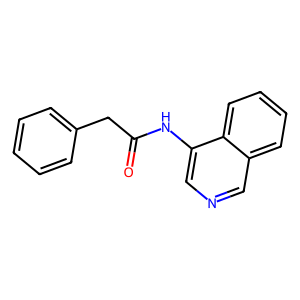

In [104]:
# Draw the structure of the most occuring Murcko scaffold
m = Chem.MolFromSmiles('O=C(Cc1ccccc1)Nc1cncc2ccccc12')
Draw.MolToImage(m)

(array([  32158.,  695284., 1905256.,  692900.,  397898.,  293802.,
         140340.,   66962.,   23230.,    4014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

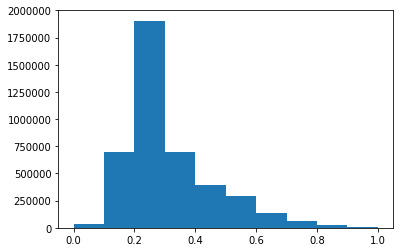

In [37]:
plt.hist(similarity_matrix.flatten())

In [38]:
cluster_result = DBSCAN(eps=0.2,min_samples=30,metric='precomputed').fit(1 - similarity_matrix)

C:\Users\henri\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


(array([1279.,  284.,   34.,  219.,  193.]),
 array([-1,  0,  1,  2,  3,  4], dtype=int64),
 <a list of 5 Patch objects>)

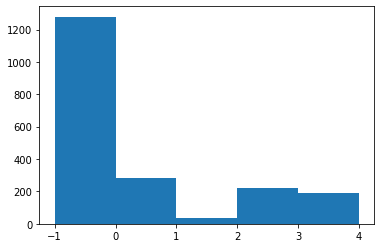

In [39]:
plt.hist(cluster_result.labels_,np.arange(np.min(cluster_result.labels_),np.max(cluster_result.labels_)),histtype='bar')

In [40]:
# We now leave the clustering
result = ClusterData(1 - similarity_matrix.flatten(),nPts=3,distThresh=0.5, isDistData=True) 

[21:13:02] WARNING: Distance matrix is too long



In [41]:
# Compute pIC50:
assays['r_avg_pIC50'] = - np.log10(assays['r_avg_IC50'])
assays['f_avg_pIC50'] = - np.log10(assays['f_avg_IC50'])

C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\henri\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([  1.,   0.,   0.,   0.,   0.,   0., 623.,  18.,  17.,  18.,  16.,
         22.,  16.,  13.,  21.,  22.,  18.,  19.,  35.,  22.,  29.,  13.,
         19.,  19.,  19.,  23.,  11.,  23.,  24.,  19.,  23.,  18.,  27.,
         20.,  22.,  25.,  23.,  23.,  22.,  20.,  22.,  28.,  22.,  21.,
         16.,  20.,  24.,  19.,  22.,  24.,  20.,  19.,  23.,  13.,  21.,
         19.,  17.,  17.,  27.,  25.,  27.,  17.,  12.,  24.,  14.,  12.,
         22.,  16.,  10.,   8.,   9.,   7.,   4.,  12.,   2.,   3.,   1.,
          0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-2.29666519, -2.24796034, -2.19925549, -2.15055065, -2.1018458 ,
        -2.05314095, -2.0044361 , -1.95573125, -1.9070264 , -1.85832155,
        -1.80961671, -1.76091186, -1.71220701, -1.66350216, -1.61479731,
        -1.56609246, -1.51738762, -1.46868277, -1.41997792, -1.37127307,
        -1.32256822, -1.27

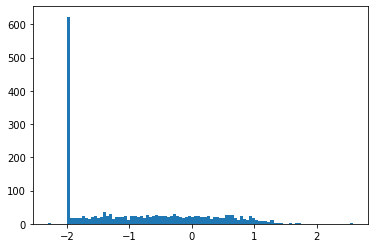

In [42]:
plt.hist(assays['f_avg_pIC50'],bins=100)


(array([255.,   5.,  13.,   3.,   8.,   4.,  12.,   7.,   6.,  14.,   3.,
          2.,   4.,  10.,   4.,   9.,   7.,   3.,  11.,   7.,   9.,  12.,
         11.,   5.,   5.,   5.,   4.,   3.,   4.,   4.,   3.,   3.,   4.,
          7.,   3.,   4.,   3.,   5.,   3.,   5.,   5.,   6.,   3.,   0.,
          7.,   3.,   4.,   9.,   8.,   5.,   5.,   7.,   4.,   9.,   4.,
          6.,   8.,   7.,   4.,   3.,  11.,   8.,   4.,   5.,   6.,   2.,
          3.,   2.,   3.,   4.,   1.,   1.,   2.,   4.,   2.,   1.,   1.,
          1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([-1.99913781e+00, -1.96145427e+00, -1.92377073e+00, -1.88608719e+00,
        -1.84840365e+00, -1.81072012e+00, -1.77303658e+00, -1.73535304e+00,
        -1.69766950e+00, -1.65998596e+00, -1.62230242e+00, -1.58461888e+00,
        -1.54693534e+00, -1.50925181e+00, -1.47156827e+00, -1.43388473e+00,
        -1.396

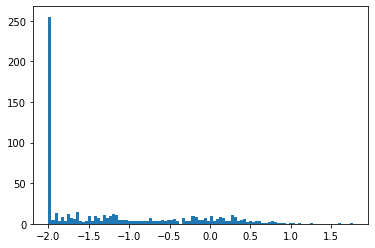

In [43]:
plt.hist(assays['r_avg_pIC50'],bins=100)

663


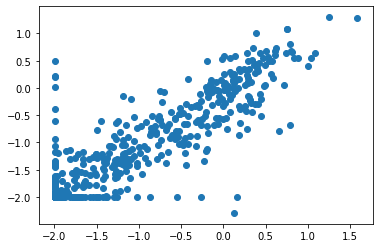

In [44]:
print(np.sum(~np.isnan(assays['r_avg_pIC50'])))
plt.scatter(assays['r_avg_pIC50'],assays['f_avg_pIC50'])

O=C(Cc1ccccc1)Nc1cncc2ccccc12                                    98
O=C(Nc1cncc2ccccc12)C1CCOc2ccccc21                               81
O=C(Nc1cncc2ccccc12)C1CNCc2ccccc21                               48
O=C1NCC(C(=O)Nc2cncc3ccccc23)c2ccccc21                           43
O=C(Cc1ccccc1)Nc1cccnc1                                          33
                                                                 ..
O=C(C(c1cccnc1)N(C(=O)c1cocn1)c1ccccc1)N1CCC(c2ccccc2)CC1         1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(-n2ccnn2)cc1      1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1ccon1)c1ccccc1                1
O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1cocn1)c1ccc(N2CCCC2=O)cc1     1
O=C(Nc1ccccc1)Nc1c[nH]c2ncccc12                                   1
Name: murcko, Length: 1179, dtype: int64

#### For the rest of the day
* plot distribution of pIC50(f&r), plot their correlations.(finished）
* Can we expand the dataset with chembl data?
* explore how to do the clustering based on similarity score (we used DBSCAN, and got 4 clusters). But the real challenge is how we interpretate the results(whether some scaffolds are overrepresented) 
* ML issues: training data, validation set, and test data.